# Tarea 1 - Taller de Modelado I (MCMAI)

**Integrantes del equipo**:  
- Diego Armando Arce Montes de Oca  
- Alan  
- Brandon  

Esta tarea tiene como objetivo aplicar el preprocesamiento de los datos, enfocándonos en:
- Limpieza y exploración de variables
- Imputación de valores faltantes con missForest en R
- Análisis de la variable SalePrice respecto a las variables predictoras




## 🔹 Montaje de Google Drive y carga de los archivos

Se Realiza la carga de las librerías, se monta Google Drive para poder acceder a los archivos de forma sencilla, que son los archivos del dataset, que existen en la carpeta /content de Colab Notebooks y que se corresponden a las variables casas, casas_kaggle.


In [49]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np

ruta = '/content/drive/MyDrive/Colab Notebooks/content/'
casas = pd.read_csv(ruta + 'Casas.csv')
casas_kaggle = pd.read_csv(ruta + 'Casas_Kaggle.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 🔹 Selección de variables y reemplazo lógico de valores faltantes

En esta parte se selecciona el subconjunto de variables indicadas por el profesor y se imputan valores lógicos en variables donde Nan representa la ausencia de una cualidad (como chimenea o sótano).


In [50]:
variables = [
    'SalePrice', 'MSZoning', 'LotArea', 'Street', 'Neighborhood', 'YearBuilt',
    'OverallCond', 'ExterQual', 'GrLivArea', 'FullBath', 'GarageArea',
    'BsmtCond', 'FireplaceQu', 'Electrical', 'LotFrontage', 'KitchenQual', 'PavedDrive'
]

casas = casas[variables].copy()
casas_kaggle = casas_kaggle[[v for v in variables if v != 'SalePrice']].copy()

# Imputación lógica para cualidades ausentes
for col in ['FireplaceQu', 'BsmtCond']:
    casas.loc[:, col] = casas[col].fillna('None')
    casas_kaggle.loc[:, col] = casas_kaggle[col].fillna('None')




## 🔹 Instalación del entorno R y del paquete missForest

Se instala rpy2 para correr código de R desde Python. También se instala y carga el paquete missForest, que permite imputar valores faltantes mediante árboles aleatorios en R.


In [51]:
!pip install -q rpy2
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [52]:
%%R
install.packages("missForest")
library(missForest)


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cran.rstudio.com/src/contrib/missForest_1.5.tar.gz'
Content type 'application/x-gzip' length 316147 bytes (308 KB)
downloaded 308 KB


The downloaded source packages are in
	‘/tmp/Rtmp5uZlnB/downloaded_packages’


### 🔹 Imputación de datos faltantes usando el algoritmo MissForest en R

En esta sección se realiza la imputación de datos faltantes usando el algoritmo **MissForest**, que es una técnica basada en bosques aleatorios (Random Forests) para imputar tanto variables numéricas como categóricas de manera no paramétrica.

Dado que el algoritmo original está implementado en R, se utiliza la interfaz rpy2 para ejecutar código R desde Google Colab.

####  Procedimiento realizado:

1. Se envió el DataFrame casas de Python a R como casas_r.
2. Se convirtieron las columnas categóricas (character) en factores (factor), tal como lo requiere MissForest.
3. Se ejecutó missForest() con semilla aleatoria fija (set.seed(123)) para garantizar reproducibilidad.
4. Después de la imputación, los factores se **convirtieron nuevamente a texto (character)** para evitar que las categorías regresaran a Python como valores numéricos (por ejemplo, "RL" → 4).
5. Finalmente, se recuperó el DataFrame imputado (casas_imputadas) de vuelta en Python y se guardó como casas_preprocesadas.csv.

Es importante mencionar que ciertos valores como "None" (por ejemplo, en la columna FireplaceQu) **no son considerados datos faltantes reales**, sino categorías válidas que indican la ausencia de una característica (por ejemplo, ausencia de chimenea), y por tanto **no fueron imputados**, sino preservados.


In [53]:
from rpy2.robjects import pandas2ri, globalenv
pandas2ri.activate()

casas_r = casas.copy()
casas_r.replace("NA", np.nan, inplace=True)
globalenv['casas_r'] = pandas2ri.py2rpy(casas_r)


In [54]:
%%R
# Convertimos columnas tipo "character" a "factor"
for (col in names(casas_r)) {
  if (class(casas_r[[col]]) == "character") {
    casas_r[[col]] <- as.factor(casas_r[[col]])
  }
}

set.seed(123)
casas_imputadas <- missForest(casas_r)$ximp

# Convertimos los factores resultantes a texto para no perder etiquetas
casas_imputadas[] <- lapply(casas_imputadas, function(x) {
  if (is.factor(x)) as.character(x) else x
})


In [55]:
#Recuperamos el archivo a python y guardamos el archivo imputado
casas_final = pandas2ri.rpy2py(globalenv['casas_imputadas'])
casas_final.to_csv(ruta + 'casas_preprocesadas.csv', index=False)



# 🔹 Imputación multivariada con missForest (Casas_Kaggle.csv)

Se repite el mismo proceso de imputación para el conjunto de prueba Casas_Kaggle.csv. El objetivo es mantener consistencia con los datos de entrenamiento.


In [56]:
casas_kaggle_r = casas_kaggle.copy()
casas_kaggle_r.replace("NA", np.nan, inplace=True)
globalenv['casas_kaggle_r'] = pandas2ri.py2rpy(casas_kaggle_r)


In [57]:
%%R
# Convertimos columnas tipo "character" a "factor"
for (col in names(casas_kaggle_r)) {
  if (class(casas_kaggle_r[[col]]) == "character") {
    casas_kaggle_r[[col]] <- as.factor(casas_kaggle_r[[col]])
  }
}

set.seed(123)
casas_kaggle_imputadas <- missForest(casas_kaggle_r)$ximp

# Convertimos factores a texto para que no regresen como números
casas_kaggle_imputadas[] <- lapply(casas_kaggle_imputadas, function(x) {
  if (is.factor(x)) as.character(x) else x
})


In [58]:
#Recuperamos el archivo a python y guardamos el archivo imputado
casas_kaggle_final = pandas2ri.rpy2py(globalenv['casas_kaggle_imputadas'])
casas_kaggle_final.to_csv(ruta + 'casas_kaggle_preprocesadas.csv', index=False)



###🔹 Análisis de la distribución de SalePrice

En esta sección se analiza la distribución de la variable de respuesta SalePrice (precio de venta de las casas). Para ello, se utilizó un histograma acompañado de una curva KDE (Kernel Density Estimation), que nos permite observar la forma de la distribución de los datos.

Este análisis ayuda a identificar si los precios siguen una distribución normal o si están sesgados, lo cual es importante para futuras transformaciones, modelado o interpretación de resultados.




La distribución de SalePrice es asimétrica hacia la derecha, con la mayoría de los precios concentrados entre 100,000 y 200,000. Hay pocas viviendas con precios muy altos, lo que genera una cola larga. Esta forma sugiere que no sigue una distribución normal, algo a considerar si se aplican modelos sensibles a la forma de la variable.



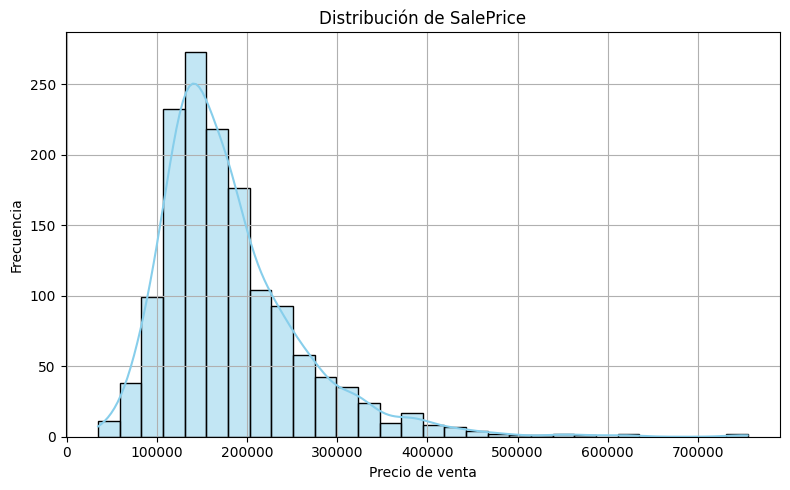

In [59]:
# Distribución de SalePrice con histograma y curva KDE

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

ruta = '/content/drive/MyDrive/Colab Notebooks/content/'
casas_final = pd.read_csv(ruta + 'casas_preprocesadas.csv')

# Asegurar que SalePrice sea numérico y eliminar NaNs
casas_final['SalePrice'] = pd.to_numeric(casas_final['SalePrice'], errors='coerce')
saleprice_data = casas_final['SalePrice'].dropna()

plt.figure(figsize=(8, 5))
sns.histplot(saleprice_data, kde=True, color='skyblue', bins=30)
plt.title('Distribución de SalePrice')
plt.xlabel('Precio de venta')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()


### 🔹 Relación de SalePrice con variables continuas

En esta sección se estudia la relación entre SalePrice y diferentes variables continuas como LotArea, YearBuil, GrLivArea, GarageArea y LotFrontage. Estas variables tienen un carácter numérico y representan dimensiones físicas o características medibles de las propiedades.

Se generaron gráficos de dispersión (scatterplots) para visualizar la correlación entre cada variable y el precio de venta. Estos gráficos permiten identificar tendencias lineales, agrupamientos, valores atípicos y posibles relaciones que podrían ser útiles en el modelado predictivo.


1. **LotArea:** Hay muchos puntos con áreas pequeñas, lo que hace difícil notar una tendencia clara. Aunque hay terrenos grandes con precios altos, también encontramos algunos que son raros y están por ahí.
2. **YearBuilt:** Se nota que las casas más nuevas suelen venderse a precios más altos. Desde el año 2000, los precios han subido bastante.
3. **GrLivArea:** Esta variable se relaciona claramente con el precio de venta. Cuanto más grande es el área habitable, más alto es el precio. Es una de las que mejor se parece al precio en los gráficos.
4. **GarageArea:** También tiene una relación positiva con el precio de venta. No es tan fuerte como la de GrLivArea, pero el tamaño del garaje sí afecta el valor, sobre todo cuando tiene entre 400 y 500 unidades.
5. **LotFrontage:** Hay una ligera tendencia al alza, aunque los datos están más dispersos. Algunos lotes con frentes grandes no siempre tienen precios más altos, así que esa relación no es muy fuerte.

En general, GrLivArea y YearBuilt parecen ser las variables continuas que más influyen en SalePrice.

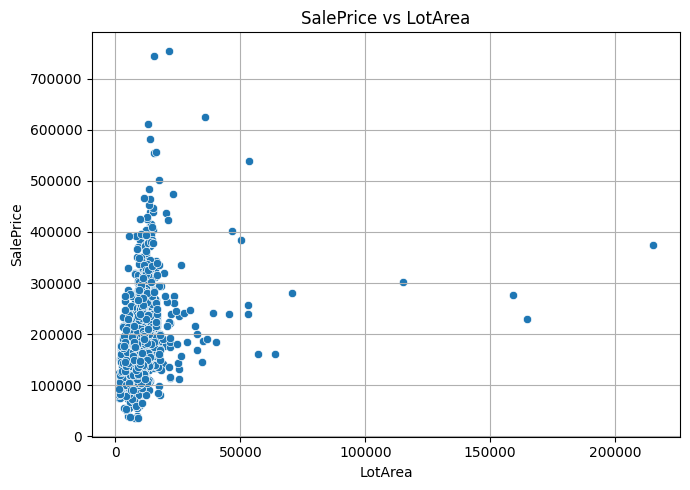

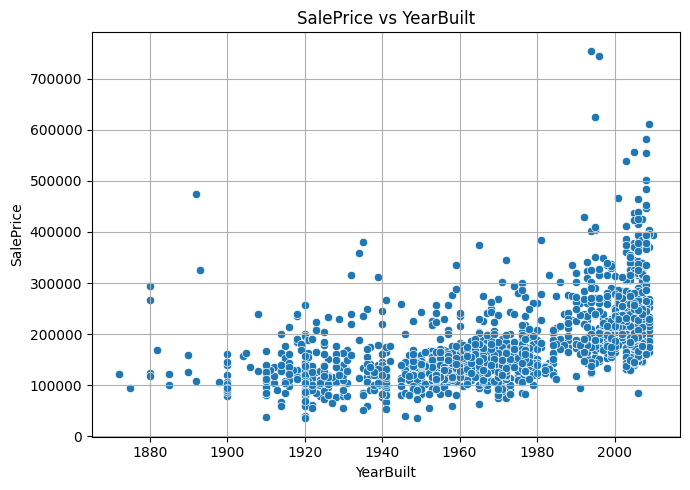

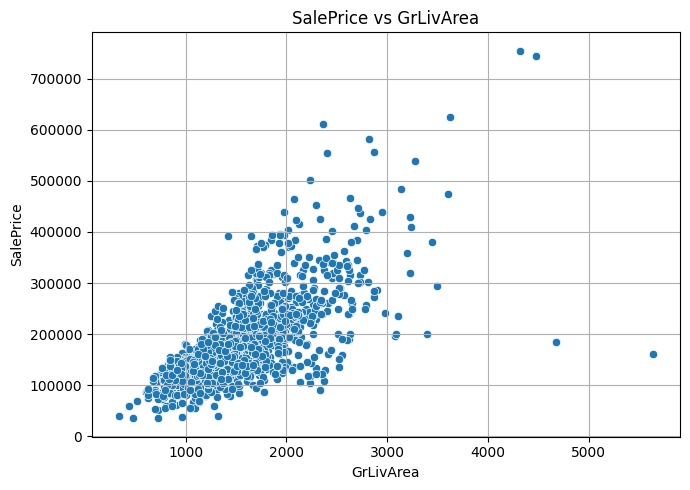

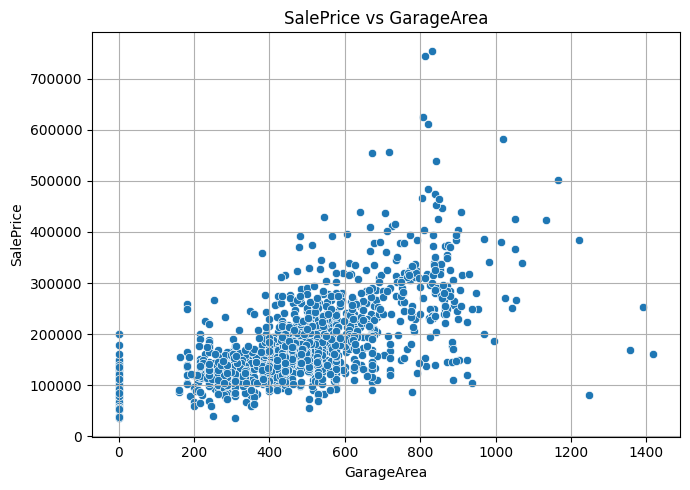

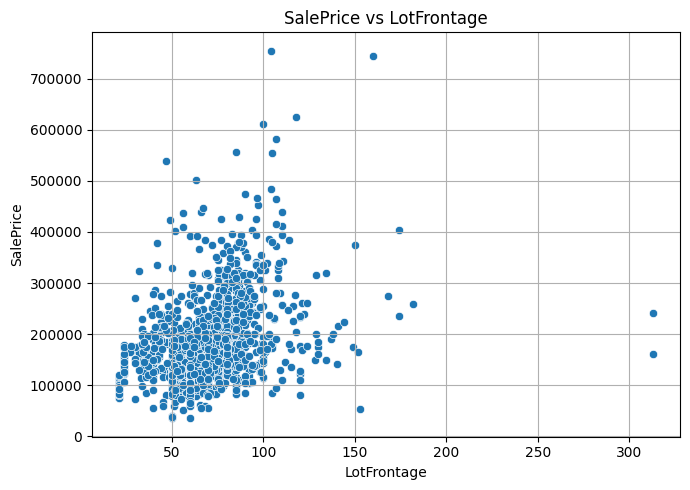

In [60]:
# Relación de SalePrice con variables continuas

variables_continuas = ['LotArea', 'YearBuilt', 'GrLivArea', 'GarageArea', 'LotFrontage']

# Verificar que existan y que sean numéricas
for col in variables_continuas:
    if col in casas_final.columns:
        casas_final[col] = pd.to_numeric(casas_final[col], errors='coerce')
        plt.figure(figsize=(7, 5))
        sns.scatterplot(data=casas_final, x=col, y='SalePrice')
        plt.title(f'SalePrice vs {col}')
        plt.xlabel(col)
        plt.ylabel('SalePrice')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


###🔹 Relación de SalePrice con variables ordinales o categóricas

En esta sección se analiza cómo varía SalePrice respecto a variables categóricas de tipo ordinal, como ExterQual, FireplaceQu, BsmtCond y KitchenQual. Estas variables describen características cualitativas de las casas, usualmente con niveles de calidad o condición.

Se utilizaron diagramas de caja (boxplots) para comparar la distribución del precio de venta entre los diferentes niveles de cada variable. Esto permite observar si existen diferencias sistemáticas en el precio según el nivel cualitativo, lo cual es clave para el análisis de impacto de calidad y diseño en el valor final de las viviendas.


1. KitchenQual: Se ve una tendencia bastante clara: las casas con cocinas de alta calidad (Ex) se venden por mucho más que las que tienen calidad regular (TA) o baja (Fa). Así que parece que la cocina juega un papel importante en el valor de la casa.

2. ExterQual: Algo parecido pasa con las casas que tienen mejores acabados exteriores (Ex), ya que su valor de mercado también es más alto. Los boxplots muestran diferencias bastante marcadas entre las calidades.

3. FireplaceQu: Las chimeneas de mejor calidad (Ex, Gd) están relacionadas con un mayor SalePrice. Aunque hay más variabilidad en los precios en todos los niveles, la tendencia sigue siendo clara: mejor calidad significa un mayor precio.

4. BsmtCond: La mayoría de las casas están en la categoría TA, pero las que tienen un sótano en buena condición (Gd) tienden a tener precios un poquito más altos. La diferencia no es tan marcada como en otras variables, pero se puede notar la relación.

En conjunto, estas variables categóricas tienen impacto importante en el precio de venta, especialmente KitchenQual y ExterQual.

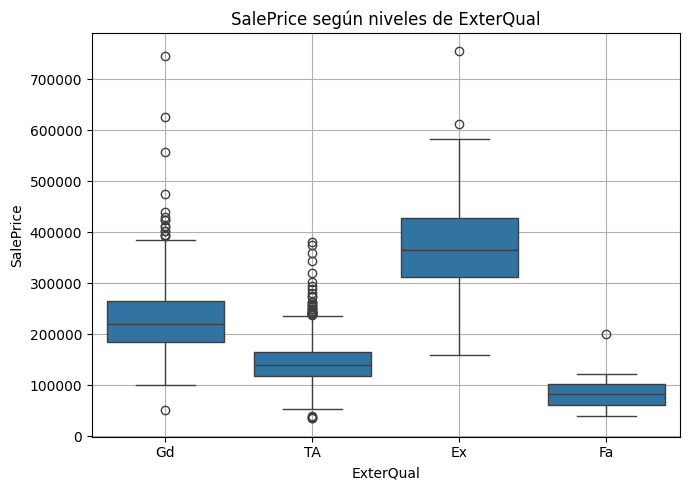

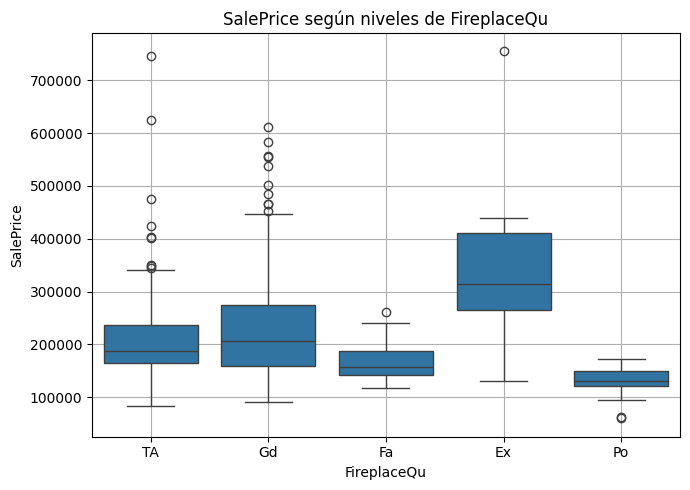

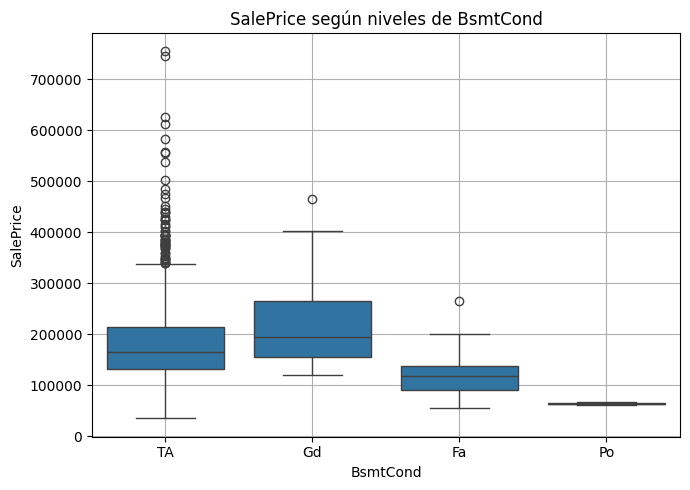

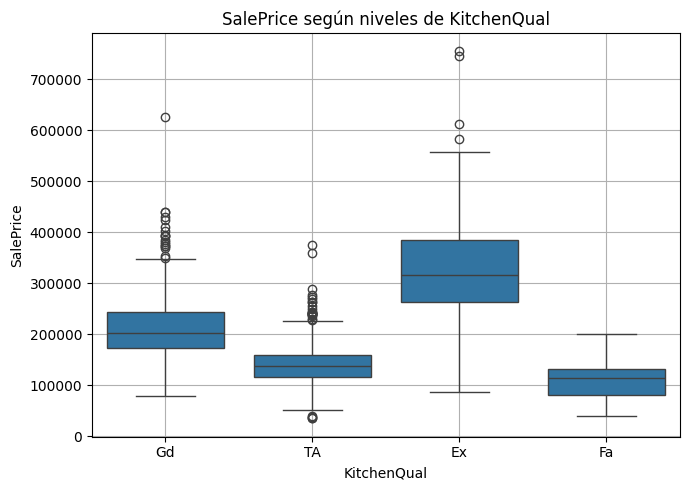

In [61]:
# Relación de SalePrice con variables ordinales o categóricas

variables_ordinales = ['ExterQual', 'FireplaceQu', 'BsmtCond', 'KitchenQual']

for col in variables_ordinales:
    if col in casas_final.columns:
        plt.figure(figsize=(7, 5))
        sns.boxplot(data=casas_final, x=col, y='SalePrice')
        plt.title(f'SalePrice según niveles de {col}')
        plt.xlabel(col)
        plt.ylabel('SalePrice')
        plt.grid(True)
        plt.tight_layout()
        plt.show()


#Analisis de las 5 columnas


#Columna – **LotFrontage**

Esta columna representa la longitud del frente del lote de la propiedad, es decir, la cantidad de pies lineales que tiene el terreno en contacto con la calle (en pies).

Al ser una variable continua, puede tomar una amplia gama de valores. Según la descripción estadística obtenida, los valores típicos se encuentran entre 60 y 80 pies, aunque hay propiedades con frentes tan amplios como más de 300 pies, lo cual genera algunos valores atípicos.



In [62]:
casas_final["LotFrontage"].head()


,LotFrontage
0,65.0
1,80.0
2,68.0
3,60.0
4,84.0


Vemos que es una variable continua, asi que podemos optener un resumen estadistico de la variable si usamos el metodo .describe()

In [63]:
casas_final['LotFrontage'].describe()


,LotFrontage
count,1460.000000
mean,70.626547
std,22.968865
min,21.000000
25%,60.000000
50%,70.000000
75%,80.531366
max,313.000000


Podemos hacer un histograma para poder visualizar estas descripciones.

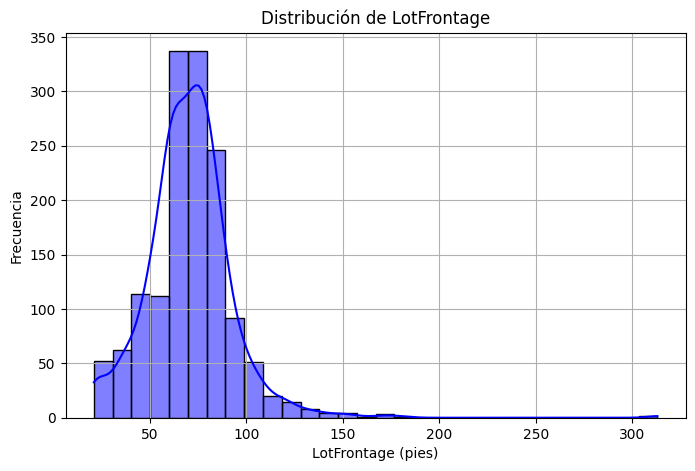

In [64]:
plt.figure(figsize=(8, 5))
sns.histplot(casas_final['LotFrontage'], bins=30, kde=True, color='blue')
plt.title('Distribución de LotFrontage')
plt.xlabel('LotFrontage (pies)')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()



La distribución de LotFrontage presenta una forma asimétrica hacia la derecha. La mayoría de los datos se concentran entre 50 y 100 pies de frente. La curva KDE en azul oscuro permite visualizar mejor el sesgo positivo y la presencia de lotes con frentes inusualmente largos (hasta más de 300 pies).



Podemos hacer un boxplot para ver de una manera mejor los valores atipicos de la variable LotFrontage.

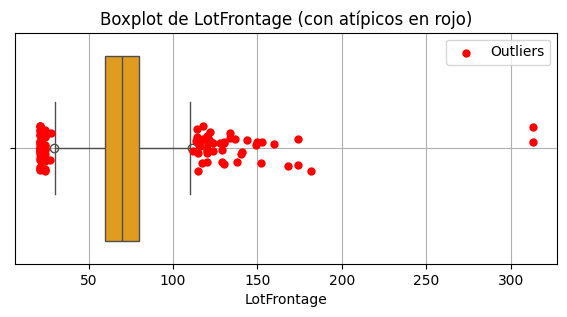

In [65]:
import numpy as np

# Calcular valores atípicos
Q1 = casas_final['LotFrontage'].quantile(0.25)
Q3 = casas_final['LotFrontage'].quantile(0.75)
IQR = Q3 - Q1
limite_sup = Q3 + 1.5 * IQR
limite_inf = Q1 - 1.5 * IQR

# Separar atípicos
outliers = casas_final[(casas_final['LotFrontage'] > limite_sup) | (casas_final['LotFrontage'] < limite_inf)]['LotFrontage']
normales = casas_final[(casas_final['LotFrontage'] <= limite_sup) & (casas_final['LotFrontage'] >= limite_inf)]['LotFrontage']

# Graficar boxplot personalizado
plt.figure(figsize=(7, 3))
sns.boxplot(x=normales, color='orange')
sns.stripplot(x=outliers, color='red', size=6, jitter=True, label='Outliers')
plt.title('Boxplot de LotFrontage (con atípicos en rojo)')
plt.xlabel('LotFrontage')
plt.grid(True)
plt.legend()
plt.show()



El boxplot de la variable LotFrontage muestra una concentración de valores entre aproximadamente 60 y 100 pies, lo cual se alinea con el rango intercuartílico (IQR) observado previamente.

Los valores atípicos (outliers) están marcados en rojo y se encuentran principalmente en dos extremos:

En el extremo izquierdo: algunos valores por debajo del mínimo típico (menores a 30 pies).

En el extremo derecho: propiedades con frentes de lote muy amplios, incluso mayores a 150 o hasta más de 300 pies.

Estos outliers pueden ser propiedades inusuales (como mansiones o terrenos irregulares) y es importante analizarlos por separado si se desea evitar que distorsionen modelos estadísticos. La cantidad de valores atípicos a la derecha sugiere una asimetría positiva en la variable.


Veamos que tan correlacionadas estan las variables LongFrontage y SalePrice

In [66]:
casas_final[['LotFrontage', 'SalePrice']].corr()



,LotFrontage,SalePrice
LotFrontage,1.000000,0.356091
SalePrice,0.356091,1.000000


La correlación de Pearson calculada entre estas dos variables es de 0.356, lo que indica una correlación positiva moderada. Es decir, aunque existe una relación directa entre ambas variables, esta no es suficientemente fuerte como para predecir el precio de venta únicamente con LotFrontage, pero sí sugiere que puede ser útil como variable complementaria dentro de un modelo multivariable.

Realizemos la grafica de dispercion de la variable LotFrontage vs SalePrice

<Axes: xlabel='LotFrontage', ylabel='SalePrice'>

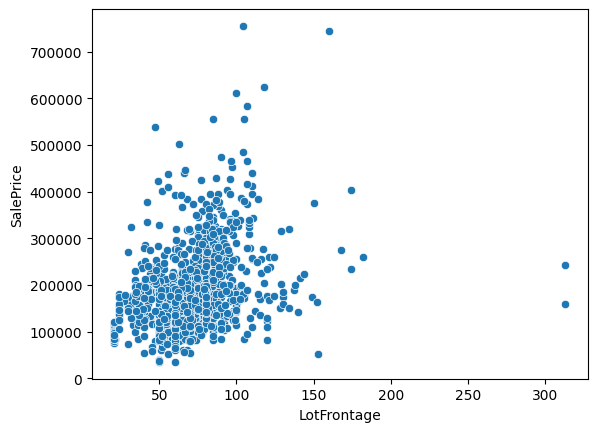

In [67]:
sns.scatterplot(x='LotFrontage', y='SalePrice', data=casas_final)


La gráfica de dispersión muestra la relación entre la longitud del frente del lote (LotFrontage) y el precio de venta de la vivienda (SalePrice). Visualmente, se aprecia una tendencia ascendente general: a mayor frente de lote, el precio de venta tiende a ser más alto.

Sin embargo, esta relación no es perfectamente lineal, ya que hay bastante dispersión en los puntos, especialmente entre 50 y 100 pies.

##Conclusiones sobre la variable **LotFrontage**
LotFrontage es una variable cuantitativa continua que representa el tamaño del

*   LotFrontage es una variable cuantitativa continua que representa el tamaño del frente del lote en pies
*   La distribución de sus valores es asimétrica hacia la derecha, con la mayoría de los casos concentrados entre 60 y 80 pies
*   Existen varios valores atípicos, principalmente hacia la derecha (mayores a 150 pies), lo cual puede deberse a terrenos atípicos o propiedades especiales como mansiones o esquinas
*   El boxplot confirmó estos outliers, los cuales deben tratarse con cuidado si se utilizan modelos sensibles a valores extremos.
*   La correlación de Pearson con SalePrice fue de 0.356, lo cual indica una relación positiva moderada: en general, a mayor frente de lote, mayor tiende a ser el precio, pero con bastante dispersión.
*   La gráfica de dispersión también reflejó esta relación, mostrando que aunque existe una tendencia creciente, no es lo suficientemente fuerte como para ser usada como predictor único, pero sí útil como variable de apoyo en modelos multivariados.


#Columna – **FireplaceQu**

La variable FireplaceQu representa la calidad de la chimenea de la vivienda, en caso de tenerla. Al ser una variable ordinal, los niveles representan un orden jerárquico de calidad.

Estos son los valores que puede tomar:


*   **Ex** — Excelente calidad

*   **Gd** — Buena calidad
*   **TA** — Calidad promedio
*   **Fa** — Calidad regular o deficiente
*   **Po** — Mala calidad


*   **None** — Sin chimenea (valor faltante imputado)






Podemos visualizar los primeros valores con:

In [68]:
casas_final['FireplaceQu'] = casas_final['FireplaceQu'].fillna('None')

In [69]:
casas_final["FireplaceQu"].head()


,FireplaceQu
0,None
1,TA
2,TA
3,Gd
4,TA


Y ver la frecuencia con:

In [70]:
casas_final["FireplaceQu"].value_counts(dropna=False)


,count
FireplaceQu,
None,690
Gd,380
TA,313
Fa,33
Ex,24
Po,20


Podemos hacer un boxplot de estas categorias:

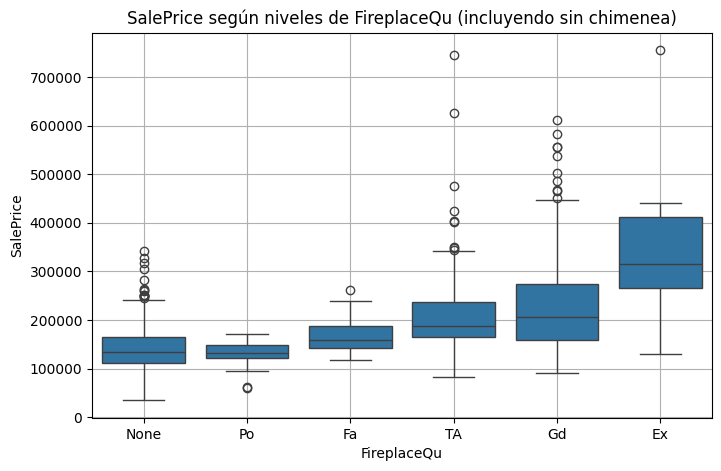

In [71]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=casas_final, x='FireplaceQu', y='SalePrice',
            order=['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'])
plt.title('SalePrice según niveles de FireplaceQu (incluyendo sin chimenea)')
plt.xlabel('FireplaceQu')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()




Vease que las viviendas sin chimenea (None) presentan precios más bajos y concentrados, lo que sugiere que la mera presencia de una chimenea ya representa un valor agregado para la propiedad. Conforme mejora la calidad de la chimenea, el precio de venta tiende a incrementarse, lo cual confirma la relación ordinal lógica de esta variable. Además, las casas con chimeneas de calidad Gd y Ex no solo exhiben precios más altos, sino también una mayor dispersión, lo que indica que estas chimeneas suelen encontrarse en viviendas de gama media-alta o premium. Finalmente, la diferencia observada entre las categorías None, Po y Fa es significativa, mostrando que incluso una chimenea de baja calidad puede ser mejor valorada por los compradores que no tener ninguna.









##Conclusiones sobre la variable **FireplaceQu**


*   FireplaceQu es una variable categórica ordinal que representa la calidad de la chimenea, y se relaciona directamente con el precio de venta de las viviendas.

*   La inclusión de la categoría "None" permite representar correctamente a las viviendas que no tienen chimenea, las cuales constituyen casi la mitad del conjunto de datos.

*   El análisis mediante boxplot revela una relación positiva clara: conforme mejora la calidad de la chimenea (Po → Fa → TA → Gd → Ex), también aumenta el SalePrice.

*   Las viviendas sin chimenea (None) tienden a tener los precios más bajos, confirmando que la presencia de una chimenea, incluso de baja calidad, representa un valor agregado.
*   Las categorías superiores (Gd y Ex) no solo concentran precios más altos, sino también una mayor dispersión, lo cual sugiere que se encuentran en propiedades de mayor valor y más variabilidad.

#Columna – **Electrical**

La variable Electrical indica el tipo de sistema eléctrico que tiene instalada la vivienda. Es una variable nominal, ya que no existe un orden entre las categorías.

Estos son los valores que puede tomar:

*   **SBrkr** — Breakers estándar (más común)

*   **FuseA** — Fuses de 60A

*   **FuseF** — Fuses de 60A sin tierra
*   **FuseP** — Fuses de 60A (posiblemente defectuoso o parcial)



*   **Mix** — Mezcla de distintos sistemas





Podemos visualizar los primeros valores con:

In [72]:
casas_final["Electrical"].head()


,Electrical
0,SBrkr
1,SBrkr
2,SBrkr
3,SBrkr
4,SBrkr


Y ver la frecuencia de cada categoría:

In [73]:
casas_final["Electrical"].value_counts(dropna=False)


,count
Electrical,
SBrkr,1335
FuseA,94
FuseF,27
FuseP,3
Mix,1


Podemos hacer un boxplot de estas categorias:

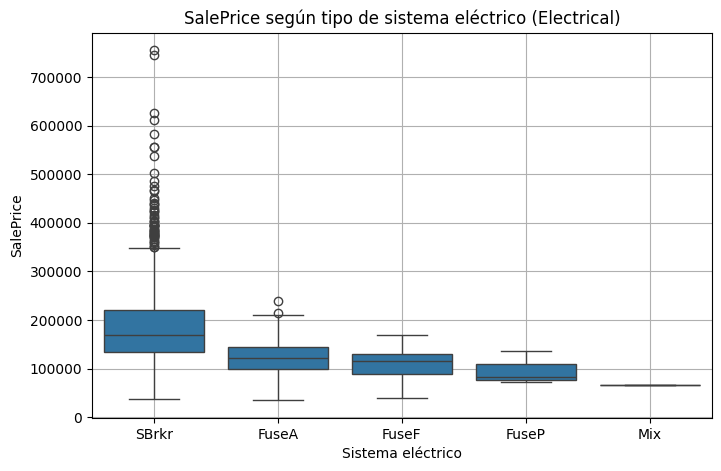

In [74]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=casas_final, x='Electrical', y='SalePrice',
            order=casas_final['Electrical'].value_counts().index)
plt.title('SalePrice según tipo de sistema eléctrico (Electrical)')
plt.xlabel('Sistema eléctrico')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()


El gráfico de cajas muestra cómo varía el precio de venta (SalePrice) en función del tipo de sistema eléctrico (Electrical). Se observa que el sistema SBrkr es el más común y está asociado con los precios de venta más altos y una mayor dispersión, lo que indica que aparece tanto en casas de gama media como en propiedades de mayor valor. En cambio, los sistemas basados en fusibles (FuseA, FuseF, FuseP) y la categoría Mix están presentes en muy pocas viviendas y se asocian con precios más bajos y menor variabilidad, lo cual puede reflejar construcciones más antiguas o instalaciones menos modernas. La clara diferencia entre SBrkr y los demás tipos sugiere que el tipo de instalación eléctrica puede influir en la percepción de valor de la vivienda, siendo SBrkr un indicador de mayor confiabilidad y modernidad.

##Conclusiones sobre la variable **Electrical**

*   La variable Electrical es categórica nominal, ya que sus valores representan tipos de sistemas eléctricos sin un orden jerárquico.

*   El valor SBrkr (sistema de interruptores) domina en frecuencia, estando presente en más del 90% de las viviendas.

*   Las casas con sistema SBrkr tienden a tener precios de venta más altos y una mayor dispersión, lo que sugiere que este sistema es más moderno y confiable.

*   Las categorías FuseA, FuseF, FuseP y Mix están presentes en muy pocas viviendas y se asocian con precios de venta más bajos y menos variables, lo cual podría estar relacionado con instalaciones antiguas o menos seguras.
*  
La variable Electrical podría estar correlacionada con la antigüedad de la construcción y es útil para complementar otras variables como YearBuilt o OverallQual.



#Columna – **KitchenQual**

La variable KitchenQual representa la calidad de la cocina de la vivienda. Al ser una variable ordinal, sus valores tienen un orden jerárquico de calidad.

Estos son los valores que puede tomar:
*   **Ex** — Excelente calidad

*   **Fa** — Calidad regular o deficiente
*   **Gd** — Buena calidad
*   **TA** — Calidad promedio

Podemos visualizar los primeros valores con:



In [75]:
casas_final["KitchenQual"].head()


,KitchenQual
0,Gd
1,TA
2,Gd
3,Gd
4,Gd


Y ver la frecuencia con:

In [76]:
casas_final["KitchenQual"].value_counts(dropna=False)


,count
KitchenQual,
TA,735
Gd,586
Ex,100
Fa,39


Podemos hacer un boxplot de estas categorías:

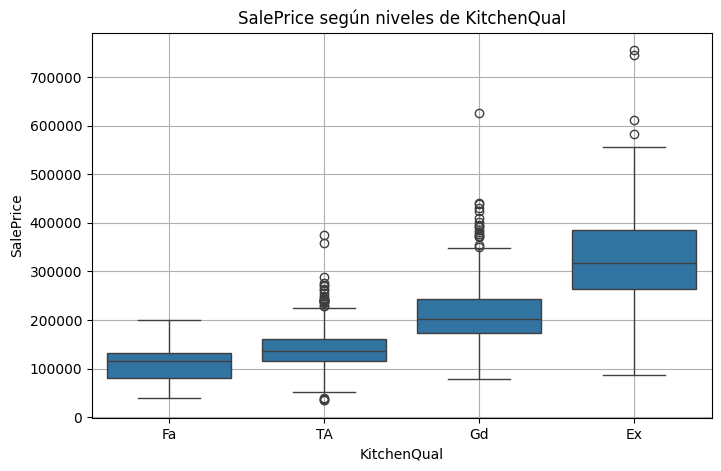

In [77]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=casas_final, x='KitchenQual', y='SalePrice',
            order=['Fa', 'TA', 'Gd', 'Ex'])
plt.title('SalePrice según niveles de KitchenQual')
plt.xlabel('KitchenQual')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()


Se observa que las viviendas con cocinas calificadas como Fa presentan los precios de venta más bajos, con poca variabilidad. Conforme aumenta la calidad de la cocina, también se incrementa el valor de la vivienda de forma clara y progresiva. Las cocinas con calidad TA  son las más frecuentes, seguidas por Gd. Finalmente, las casas con cocinas Ex  concentran los precios de venta más altos y la mayor dispersión, lo que sugiere que esta categoría está presente principalmente en viviendas de gama alta. Esta progresión ordenada confirma que KitchenQual es una variable altamente relevante para explicar el comportamiento del precio de venta.

##Conclusiones sobre la variable **KitchenQual**

*   KitchenQual es una variable categórica ordinal que representa la calidad percibida de la cocina de la vivienda.

*   Las cocinas con calificación baja (Fa) están asociadas a precios más bajos y menor variabilidad.

*  Las cocinas Gd y Ex se asocian con precios significativamente más altos y mayor dispersión, lo cual indica que están presentes en viviendas de mayor valor.

*   La relación entre KitchenQual y SalePrice es creciente y lógica, lo que confirma su utilidad como predictor en modelos de regresión o clasificación.


















#Columna – **PavedDrive**

La variable PavedDrive indica si la entrada al garaje de la vivienda está pavimentada o no. Es una variable categórica nominal, ya que sus valores representan opciones distintas sin un orden jerárquico.

Estos son los valores que puede tomar:


*   **Y** — Yes, la entrada está completamente pavimentada

*   **P** — Partial, la entrada está pavimentada parcialmente
*  **N** — No, la entrada no está pavimentada








Podemos visualizar los primeros valores con:

In [78]:
casas_final["PavedDrive"].head()


,PavedDrive
0,Y
1,Y
2,Y
3,Y
4,Y


Y ver la frecuencia con:

In [79]:
casas_final["PavedDrive"].value_counts(dropna=False)


,count
PavedDrive,
Y,1340
N,90
P,30


Podemos hacer un boxplot para comparar cómo se relaciona esta variable con el precio de venta:

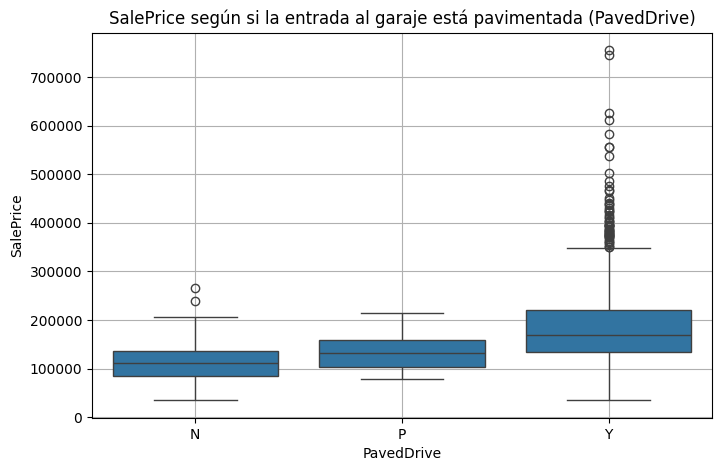

In [80]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=casas_final, x='PavedDrive', y='SalePrice',
            order=['N', 'P', 'Y'])
plt.title('SalePrice según si la entrada al garaje está pavimentada (PavedDrive)')
plt.xlabel('PavedDrive')
plt.ylabel('SalePrice')
plt.grid(True)
plt.show()


El boxplot revela que las viviendas con entrada no pavimentada (N) presentan los precios de venta más bajos y concentrados, lo que puede asociarse con viviendas más antiguas, ubicaciones rurales o menor nivel de mantenimiento. Las entradas pavimentadas parcialmente (P) muestran un ligero aumento en el precio medio, mientras que las viviendas con entradas completamente pavimentadas (Y) concentran la mayoría de los casos (1340 de 1460) y exhiben una mayor mediana de SalePrice y mayor dispersión. Este patrón indica que una entrada pavimentada no solo mejora la funcionalidad, sino también la percepción del valor del inmueble.

##Conclusiones sobre la variable **PavedDrive**

*   PavedDrive es una variable categórica nominal que refleja la condición del acceso al garaje de la vivienda..

*   Las viviendas con entrada no pavimentada (N) se asocian con los precios de venta más bajos, lo cual puede reflejar menor urbanización o mantenimiento.

*  Las entradas parcialmente pavimentadas (P) presentan una ligera mejora respecto a N, aunque su frecuencia es baja.

*   Las entradas completamente pavimentadas (Y) son las más comunes y están relacionadas con los precios más altos y una mayor variabilidad, lo cual sugiere una asociación con viviendas de mayor valor o más recientes.

* Esta variable puede mejorar el rendimiento de modelos predictivos al capturar una característica visual y funcional que impacta la percepción del comprador.
